# 08C. Particles in a box: MCMC sampling

### Mingyang Lu

### 3/11/2024

#  Particles in a box revisited

We again model a box of particles with pairwise Lennard-Jones potential. 

For the pairwise interactions:

$$F(r) = \frac{1}{r^{13}} - \frac{1}{r^7} \tag{1},$$

The corresponding potential function is

$$U(r) = \int{-F(r)dr} = \frac{1}{12r^{12}}-\frac{1}{6r^{6}}. \tag{2}$$
We can then compute the total potential for the particles in the box. We consider the periodic boundary condition, so the minimum image convention is also applied.

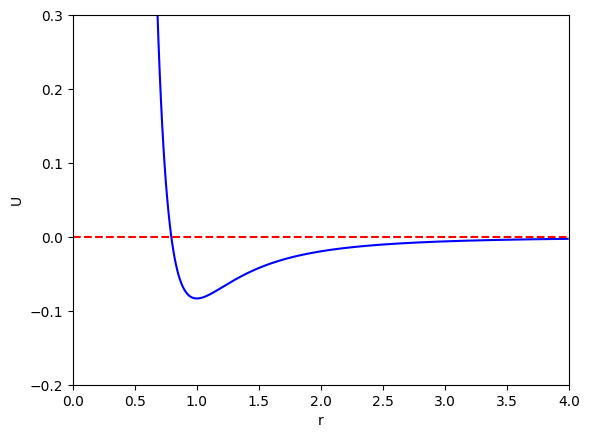

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def potential(r2):
    r4 = r2 ** 2
    r6 = r4 * r2
    r12 = r6 * r6
    u = 1 / (12 * r12) - 1 / (6 * r6)
    return u

r_all = np.arange(0.01, 4, 0.01)
U = np.array([potential(r) for r in r_all])

plt.plot(r_all, U, color='blue')
plt.xlabel('r')
plt.ylabel('U')
plt.xlim(0, 4)
plt.ylim(-0.2, 0.3)
plt.axhline(0, color='red', linestyle='--')
plt.show()

In [2]:
def minimum_image_convention(dx, a):
    return dx - np.round(dx / a) * a

def potential_ij(xi, xj, a):
    dx = xi - xj
    dx = minimum_image_convention(dx, a)
    rij2 = np.dot(dx, dx)
    return potential(rij2)

def potential_tot(x_all, a):
    Ntot = len(x_all) // 2
    p_tot = 0
    for i in range(Ntot - 1):
        xi = x_all[2 * i:2 * (i + 1)]
        for j in range(i + 1, Ntot):
            xj = x_all[2 * j:2 * (j + 1)]
            p_ij = potential_ij(xi, xj, a)
            p_tot += p_ij
    return p_tot


Interestingly, we don't need to consider the kinetic energy in the Boltzmann distribution, as the kinetic energy is only velocity dependent and can be integrated out in the partition function (we will not discuss this Statistical Mechanics topic in details). Thus, in the Metropolis-Hastings algorithm, we just need to consider the particle positions and the potential energy and just omit the velocities and the kinetic energy.

# Local move & energy updateTo efficiently sample another configuration of the system, we propose a local move, which involves a randomly selected particle and a small displacement. Such a local move would allow a small change in the total energy; therefore, the proposed move is more likely to be accepted.Below shows the calculation of the energy differences after a proposed local move. Only potential terms related to the moved particle $i$ are computed. 

In [3]:
def dp(x_all, a, x_new, i):
    xi = x_all[2 * i:2 * (i + 1)]

    Ntot = len(x_all) // 2
    p_old = 0
    p_new = 0
    for j in range(Ntot):
        if i != j:
            xj = x_all[2 * j:2 * (j + 1)]
            p_old += potential_ij(xi, xj, a)
            p_new += potential_ij(x_new, xj, a)
    return p_new - p_old


Q: How much improvement is this method in terms of computational efficiency? Is there a way to further improve the efficiency?

# Metroplis-Hastings algorithm

Specifying the initial configuration. Note that, in MCMC, only positions are needed. We also make the box size slightly larger (why?).

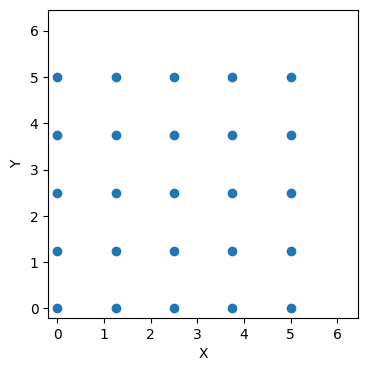

In [4]:
np.random.seed(1)
ntot = 25
a = 6.25

grid_x = np.arange(0, 6.25, 1.25)
grid_y = np.arange(0, 6.25, 1.25)
xx, yy = np.meshgrid(grid_x, grid_y)
xy0 = np.column_stack([xx.ravel(), yy.ravel()])
x0 = xy0.reshape(-1)

plt.figure(figsize=(4, 4))
plt.scatter(xy0[:, 0], xy0[:, 1], marker='o')
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(-0.2, a+0.2)
plt.ylim(-0.2, a+0.2)
plt.show()

Use Metropolis-Hastings algorithm to sample particle configurations.

In [5]:
def metropolis_particle(ntot, cal_e, cal_de, x0, dxmax, nstep, T, a):
    """
    # ntot: number of particles
    # cal_e: function to compute the total energy
    # cal_de: function to compute the energy differences
    # x0: initial configuration (a vector of size 2*ntot)
    # dxmax: maximum displacement in a proposed move (a vector of size 2)
    # nstep: number of MCMC steps
    # T: temperature (scaled)
    # a: box size
    """

    x = np.zeros((nstep + 1, 2 * ntot))  # positions
    e = np.zeros(nstep + 1)  # total energy

    x[0, :] = x0
    e[0] = cal_e(x0, a)
    num_accept = 0

    for i in range(nstep):
        k = np.random.randint(0, ntot)  # randomly select a particle
        dx = np.random.uniform(-dxmax, dxmax, size=2)
        x_new = x[i, 2 * k:2 * (k + 1)] + dx
        x_new -= np.floor(x_new / a) * a  # periodic boundary condition

        de = cal_de(x[i, :], a, x_new, k)
        if de < 0 or np.random.uniform() < np.exp(-de / T):
            x[i + 1, :] = x[i, :]
            x[i + 1, 2 * k:2 * (k + 1)] = x_new
            e[i + 1] = e[i] + de
            num_accept += 1
        else:
            x[i + 1, :] = x[i, :]
            e[i + 1] = e[i]

    print("Acceptance rate:", num_accept / nstep)
    return {"x": x, "e": e}

MCMC sampling - the initial phase. This is needed as the initial configuration has a higher energy state for $T = 0.05$. The parameter *dxmax* was selected to make the acceptance rate around 40% - 50%.

Acceptance rate: 0.4636


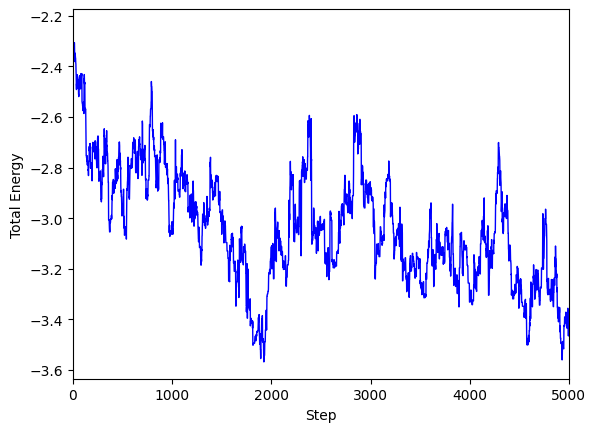

In [6]:
# Set seed (not directly equivalent to R's set.seed(10), but for reproducibility)
np.random.seed(10)

dxmax = np.array([0.25, 0.25])
T = 0.05
nstep = 5 * 10 ** 3

results_init = metropolis_particle(ntot=ntot, cal_e=potential_tot, cal_de=dp, x0=x0,
                                   dxmax=dxmax, nstep=nstep, T=T, a=a)

plt.plot(np.arange(nstep + 1), results_init['e'], color='blue', linestyle='-', linewidth=1)
plt.xlabel('Step')
plt.ylabel('Total Energy')
plt.xlim(0, nstep)
plt.show()

x1 = results_init['x'][nstep]

A particle configuration after the initial phase of the MCMC sampling.


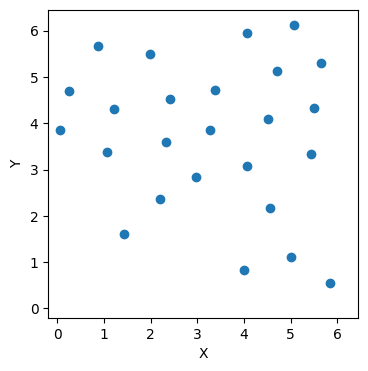

In [7]:
xy_1 = results_init['x'][nstep].reshape((-1, 2), order='C')

plt.figure(figsize=(4, 4))
plt.scatter(xy_1[:, 0], xy_1[:, 1], marker='o')
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(-0.2, a+0.2)
plt.ylim(-0.2, a+0.2)
plt.show()

A second phase of MCMC sampling, prepared for the RDF calculation later.

Acceptance rate: 0.3983


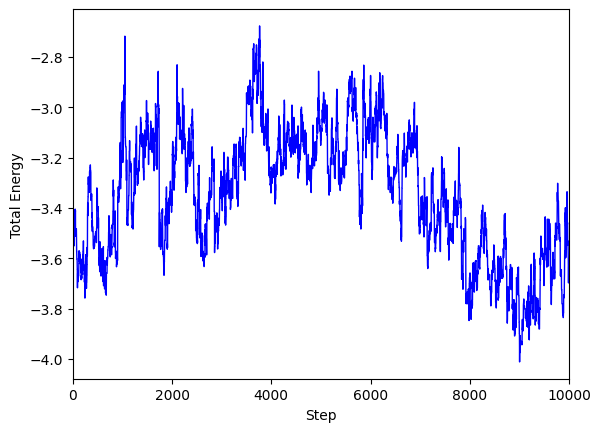

In [8]:
nstep = 1 * 10 ** 4

results_final = metropolis_particle(ntot=ntot, cal_e=potential_tot, cal_de=dp, x0=x1,
                                   dxmax=dxmax, nstep=nstep, T=T, a=a)

plt.plot(np.arange(nstep + 1), results_final['e'], color='blue', linestyle='-', linewidth=1)
plt.xlabel('Step')
plt.ylabel('Total Energy')
plt.xlim(0, nstep)
plt.show()

Q: Can we propose a move that involves displacements of multiple particles? 

## Radial distribution function

The RDF is computed by an ensemble average from the second phase of the MCMC sampling.

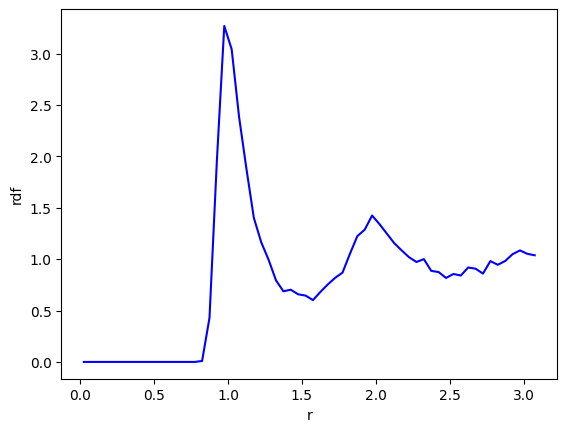

In [9]:
def cal_rdf(ntot, results, a, dr):
    nt_all = results.shape[0]
    r_all = np.arange(dr, a/2, dr)
    nr = len(r_all)
    counts = np.zeros(nr)

    for nt in range(nt_all):
        x_all = results[nt]
        for i in range(ntot):
            xi = x_all[2*i]
            yi = x_all[2*i+1]
            for j in range(ntot):
                if i != j:
                    xj = x_all[2*j]
                    yj = x_all[2*j+1]

                    dx = xi - xj
                    dx -= np.round(dx/a) * a
                    dy = yi - yj
                    dy -= np.round(dy/a) * a

                    rij = np.sqrt(dx**2 + dy**2)
                    ind = int(np.ceil(rij/dr))
                    if ind <= nr:
                        counts[ind-1] += 1

    r_mean = r_all - 0.5 * dr
    rho = counts / nt_all / ntot / (2 * np.pi * dr * r_mean)
    rho_0 = ntot / a**2
    rdf = rho / rho_0
    return r_mean, rdf

results_rdf = cal_rdf(ntot=ntot, results=results_final['x'], a=a, dr=0.05)

plt.plot(results_rdf[0], results_rdf[1], color='blue')
plt.xlabel('r')
plt.ylabel('rdf')
plt.show()

Q: Compare the results with those from an MD simulation. Which method is more efficient?